In [1]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev==2.3.29
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from pathlib import Path

def plot_label_counts(dls):
    # Inicializar listas para etiquetas de training (originales y destiladas)
    train_original_labels = []
    train_distilled_labels = []

    # Recorrer cada ejemplo en el dataset de training
    for i in range(len(dls.train_ds)):
        label = int(dls.train_ds[i][1])
        # Obtener la ruta del archivo y extraer el nombre
        path = Path(dls.train_ds.items[i])
        filename = path.name.lower()  # convertir a minúsculas para evitar problemas con mayúsculas

        # Clasificar: si el nombre comienza con 'distilled', es destilado; de lo contrario, es original.
        if filename.startswith("distilled"):
            train_distilled_labels.append(label)
        else:
            train_original_labels.append(label)

    # Para validación, todas las imágenes se consideran originales
    valid_labels = [int(dls.valid_ds[i][1]) for i in range(len(dls.valid_ds))]

    # Contar el número de ejemplos por etiqueta en cada grupo
    train_orig_counts = Counter(train_original_labels)
    train_dist_counts = Counter(train_distilled_labels)
    valid_counts = Counter(valid_labels)

    # Obtenemos el vocabulario (lista de nombres de clases) y el número de clases:
    vocab = dls.vocab
    n_classes = len(vocab)

    # Crear listas de conteos para cada clase (asumiendo índices de 0 a n_classes-1)
    orig_data = [train_orig_counts[i] for i in range(n_classes)]
    dist_data = [train_dist_counts[i] for i in range(n_classes)]
    valid_data = [valid_counts[i] for i in range(n_classes)]

    # Configurar el gráfico de barras agrupadas:
    x = np.arange(n_classes)
    width = 0.25  # ancho de cada barra, para acomodar tres barras por etiqueta

    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(x - width, orig_data, width, label='Train Original', color='blue')
    ax.bar(x, dist_data, width, label='Train Distilled', color='red')
    ax.bar(x + width, valid_data, width, label='Valid', color='yellow')

    ax.set_ylabel('Número de elementos')
    ax.set_xticks(x)
    ax.set_xticklabels(vocab)
    ax.legend()

    plt.show()


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Apartado 1

In [5]:
import os
import shutil
from pathlib import Path
from torchvision import datasets
from fastai.vision.all import *
import torch.nn as nn
import torch
from PIL import Image

# 1. Configurar FASTAI_HOME y definir rutas base
os.environ["FASTAI_HOME"] = str(Path('/content/dataset'))

base_path = Path('/content/dataset')
fashion_path = base_path / "fashion_mnist"  # Ruta donde se descargará FashionMNIST

# 2. Descargar FashionMNIST con torchvision (se obtienen imágenes PIL al usar transform=None)
train_dataset = datasets.FashionMNIST(root=str(fashion_path), train=True, download=True)
test_dataset  = datasets.FashionMNIST(root=str(fashion_path), train=False, download=True)

# 3. Definir la estructura de carpetas destino: /content/dataset/original/fashion_mnist/{train,test}/{clase}/imagen.png
dest_base   = base_path / "original" / "fashion_mnist"
train_folder = dest_base / "train"
test_folder  = dest_base / "test"

train_folder.mkdir(parents=True, exist_ok=True)
test_folder.mkdir(parents=True, exist_ok=True)

# Obtener los nombres de clases del dataset (por ejemplo: 'T-shirt/top', 'Trouser', etc.)
classes = train_dataset.classes

for idx, (img, label) in enumerate(train_dataset):
    label_name = classes[label]
    out_dir = train_folder / label_name
    out_dir.mkdir(parents=True, exist_ok=True)
    out_file = out_dir / f"{idx}.png"
    img.save(out_file)

# Guardar imágenes de test organizadas en carpetas por clase
for idx, (img, label) in enumerate(test_dataset):
    label_name = classes[label]
    out_dir = test_folder / label_name
    out_dir.mkdir(parents=True, exist_ok=True)
    out_file = out_dir / f"{idx}.png"
    img.save(out_file)


100%|██████████| 26.4M/26.4M [00:00<00:00, 118MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 4.38MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 51.9MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.5MB/s]


## Lenet

In [6]:
dataset_root = train_folder

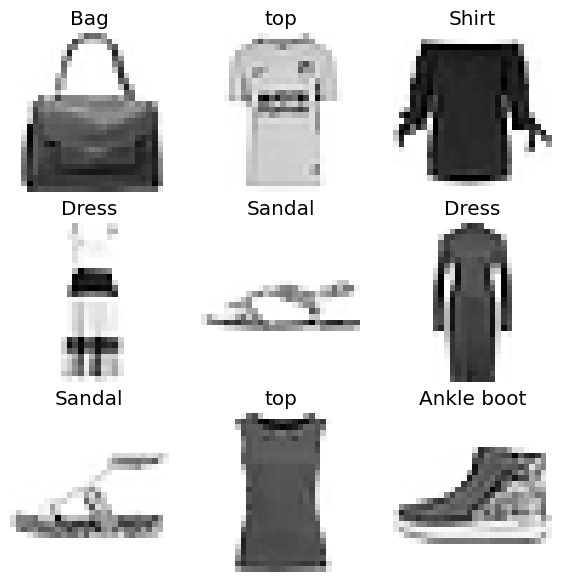

In [ ]:
# Creamos el DataBlock
blocks = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

# Generar DataLoaders a partir de la ruta indicada
dls = blocks.dataloaders(dataset_root, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 48000
Número total de imágenes en validación: 12000

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'Trouser', 'top']


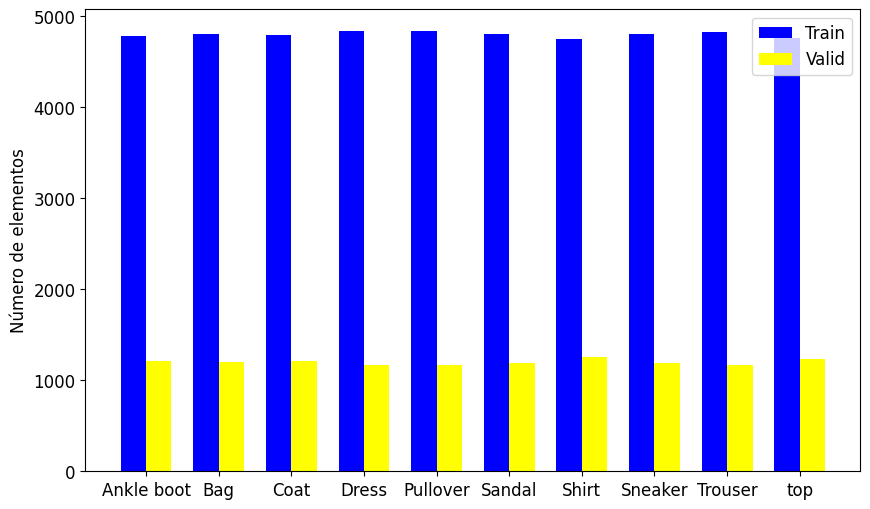

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
import torch.nn.functional as F

class LeNet(nn.Module):
  def __init__(self, num_classes=10):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(x.size(0), -1)  # Aplanar la salida
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

learn.summary()

LeNet (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 6 x 24 x 24    
Conv2d                                    156        True      
____________________________________________________________________________
                     64 x 16 x 8 x 8     
Conv2d                                    2416       True      
____________________________________________________________________________
                     64 x 16 x 4 x 4     
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 120            
Linear                                    30840      True      
____________________________________________________________________________
                     64 x 84             
Linear                                    10164      True      
____________________________________________________________

In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.990850,0.926572,0.660167,0.659593,0.632148,00:49
1,0.702241,0.668015,0.743667,0.745161,0.740910,00:56
2,0.587358,0.551684,0.797833,0.798082,0.800327,00:56
3,0.489490,0.442250,0.838500,0.839896,0.834927,00:52
4,0.409349,0.411631,0.848083,0.848377,0.845425,01:00
5,0.365879,0.350401,0.871917,0.873145,0.870094,00:53
6,0.347408,0.333913,0.878833,0.879807,0.876175,01:03
7,0.330379,0.327646,0.878333,0.878844,0.880353,00:53
8,0.294371,0.296789,0.890667,0.891081,0.891561,00:54
9,0.278894,0.295047,0.890167,0.890752,0.891445,00:54



Tiempo de entrenamiento: 1113.23 segundos


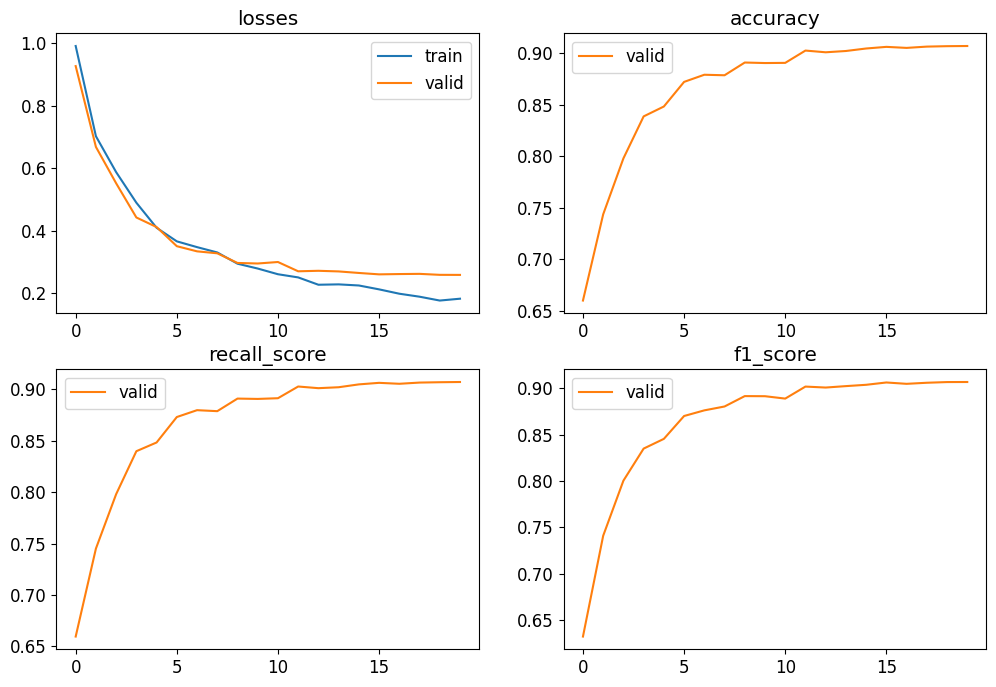

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.2586
Accuracy: 0.9067
Recall: 0.9072
F1-Score: 0.9068


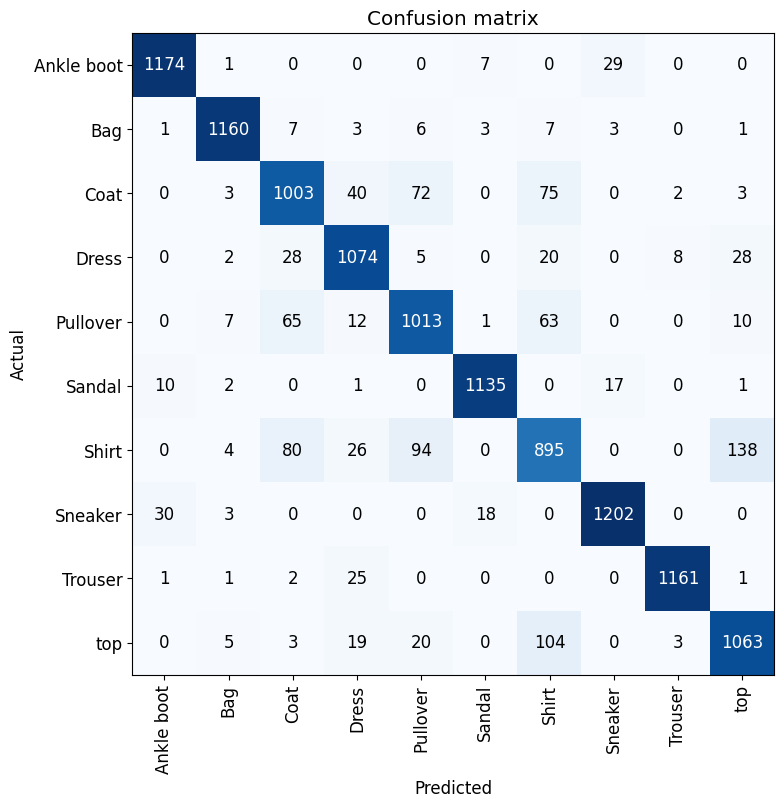

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_original_v3.pkl')

## Resnet

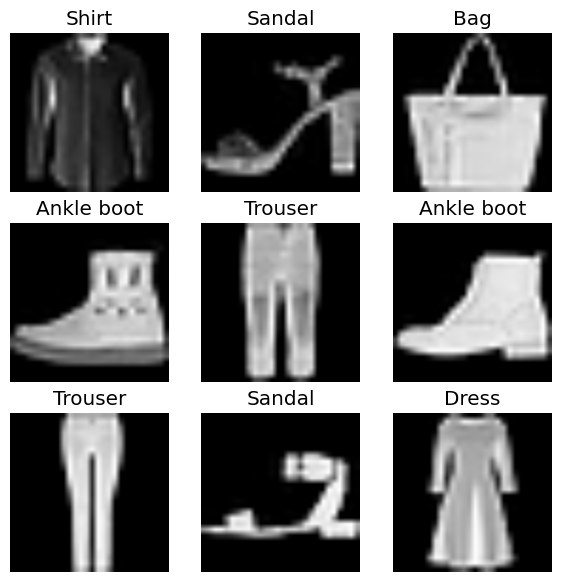

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    )

dls = dblock.dataloaders(dataset_root, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
# Crear el learner con resnet18
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

In [ ]:
# Entrenar el modelo
start_time = time.time()
learn.fit_one_cycle(30)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.638159,0.482347,0.829417,0.828009,0.827193,03:32
1,0.473046,0.395655,0.856917,0.856307,0.855928,03:28
2,0.373110,0.333889,0.872250,0.872053,0.867380,03:28
3,0.316721,0.306195,0.890583,0.889874,0.890993,03:28
4,0.267673,0.237970,0.915167,0.914547,0.913339,03:28
5,0.247592,0.233786,0.915833,0.915050,0.915372,03:27
6,0.220836,0.207168,0.924750,0.924253,0.923923,03:28
7,0.196748,0.205336,0.928417,0.927955,0.927450,03:28
8,0.166748,0.187464,0.934667,0.934082,0.933635,03:30
9,0.152017,0.205479,0.929917,0.929057,0.929680,03:28


No improvement since epoch 8: early stopping

Tiempo de entrenamiento: 2927.82 segundos


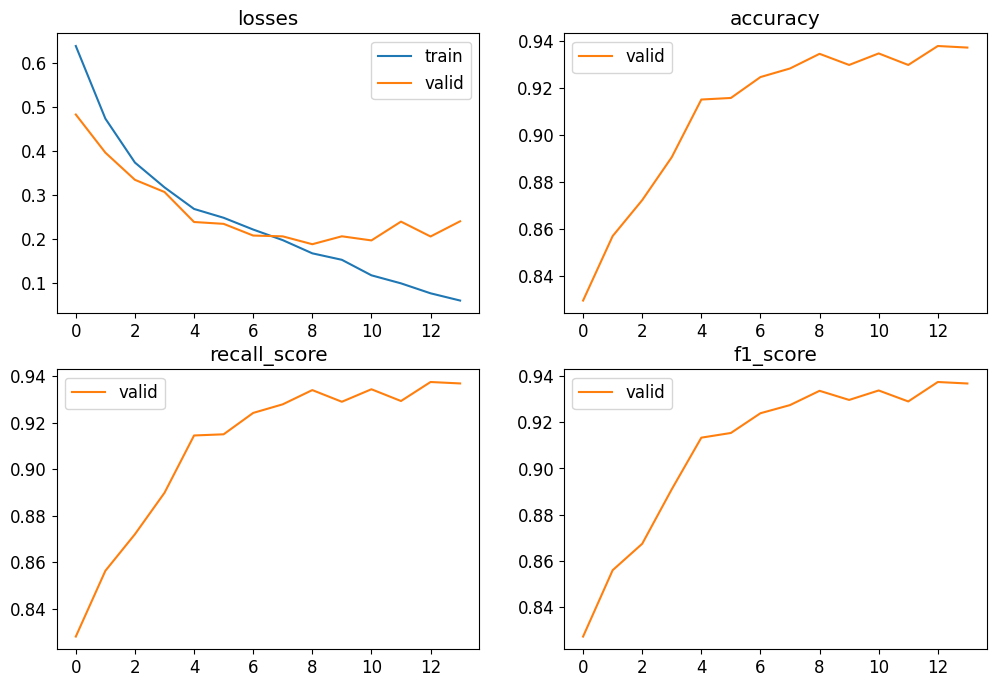

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.2396
Accuracy: 0.9373
Recall: 0.9369
F1-Score: 0.9368


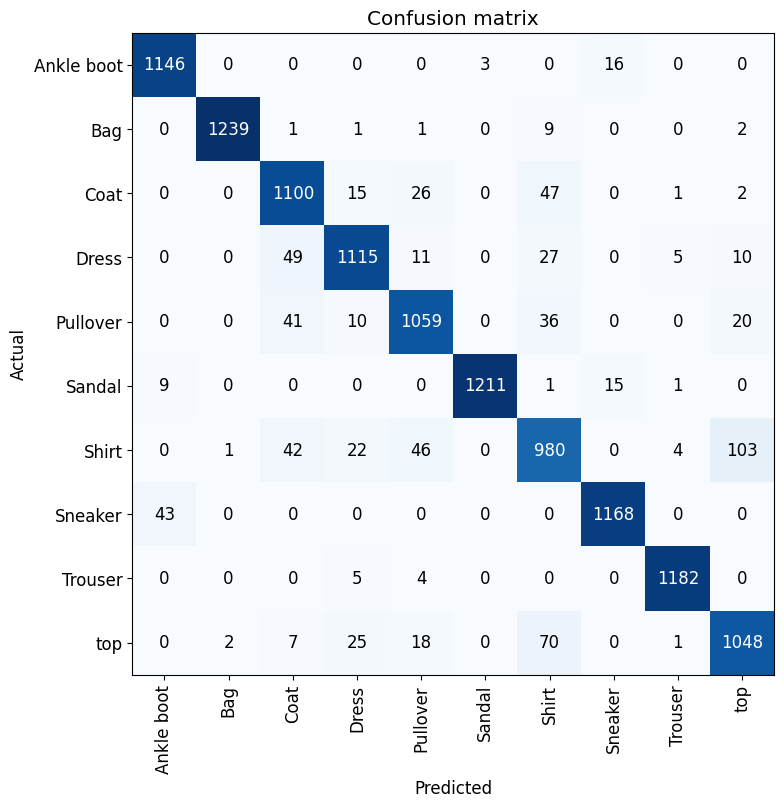

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_original_v3.pkl')

# Apartado 2

## Destilacion de datos

In [7]:
import random
import shutil
from pathlib import Path
import numpy as np
from PIL import Image

def media_arit(image_paths):
    avg_image = None
    count = 0
    # Sumar todas las imágenes (convertidas a array NumPy)
    for img_path in image_paths:
        with Image.open(img_path) as img:
            np_img = np.array(img, dtype=np.float32)
            if avg_image is None:
                avg_image = np_img
            else:
                avg_image += np_img
            count += 1
    # Calcular la media y convertir a uint8
    avg_image /= count
    avg_image = np.clip(avg_image, 0, 255).astype(np.uint8)
    return Image.fromarray(avg_image, mode='L')


In [8]:
def create_partial_distilled(src_path, dst_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=1, mix_function=media_arit):
    """
    Crea un nuevo dataset a partir de src_path con la siguiente estrategia:

      - Se divide en 80% training y 20% validación (valid_ratio).
      - En el conjunto de training:
          * El 80% de las imágenes se procesan mediante destilación usando mix_function.
          * El 20% restante se copia sin modificar.
      - En el conjunto de validación se copian las imágenes sin modificaciones.

    Parámetros:
      src_path: Ruta a la carpeta original, que debe tener subcarpetas para cada clase.
      dst_path: Ruta destino para el nuevo dataset.
      valid_ratio: Proporción de imágenes para validación (ej. 0.2 para 20%).
      distilled_portion: Proporción de imágenes dentro del training que serán destiladas (ej. 0.8 para 80%).
      group_fraction:
          * Si es 1, se mezclan todas las imágenes del subconjunto de destilación en una sola imagen.
          * Si es un valor entre 0 y 1, se agrupan en bloques cuyo tamaño es group_size = int(len(distilled_images) * group_fraction).
          * Si es 0, se procesa cada imagen individualmente (aunque normalmente querrás usar 1 o un valor intermedio).
      mix_function: Función que recibe una lista de rutas de imágenes y devuelve una imagen destilada.
    """
    src_path = Path(src_path)
    dst_path = Path(dst_path)

    # Eliminar dst_path si ya existe
    if dst_path.exists():
        shutil.rmtree(dst_path)
    dst_path.mkdir(parents=True, exist_ok=True)

    # Crear directorios para training y validación
    train_dst = dst_path / "training"
    valid_dst = dst_path / "valid"
    train_dst.mkdir(parents=True, exist_ok=True)
    valid_dst.mkdir(parents=True, exist_ok=True)

    # Procesar cada subcarpeta (clase) en src_path
    for class_dir in src_path.iterdir():
        if not class_dir.is_dir():
            continue

        if class_dir.name.lower() == "t-shirt":
            images = list(class_dir.glob('**/*.*'))
        else:
            images = list(class_dir.glob('*.*'))
        if not images:
            continue

        # Barajar y separar en training y validación
        random.shuffle(images)
        total = len(images)
        n_valid = int(total * valid_ratio)
        n_train = total - n_valid

        train_images = images[:n_train]
        valid_images = images[n_train:]

        # Dentro de training, separar el 80% para destilación y el 20% para copiar sin modificar
        n_train_distilled = int(n_train * distilled_portion)
        n_train_original = n_train - n_train_distilled

        distilled_images = train_images[:n_train_distilled]
        original_train_images = train_images[n_train_distilled:]

        # Crear subdirectorios para la clase en training y validación
        new_train_class_dir = train_dst / class_dir.name
        new_train_class_dir.mkdir(parents=True, exist_ok=True)
        new_valid_class_dir = valid_dst / class_dir.name
        new_valid_class_dir.mkdir(parents=True, exist_ok=True)

        # Procesar las imágenes para destilación (80% del conjunto de training)
        if group_fraction == 0:
            # Procesar cada imagen individualmente (aunque esto normalmente no es lo esperado)
            for img_path in distilled_images:
                distilled_img = mix_function([img_path])
                # Se guarda con el mismo nombre original
                new_file = new_train_class_dir / img_path.name
                distilled_img.save(new_file)
        elif group_fraction == 1:
            # Mezclar todas las imágenes del subconjunto en una sola imagen destilada
            distilled_img = mix_function(distilled_images)
            distilled_filename = new_train_class_dir / "distilled.jpg"
            distilled_img.save(distilled_filename)
        else:
            # Agrupar las imágenes en bloques
            group_size = max(1, int(len(distilled_images) * group_fraction))
            group_count = 0
            for i in range(0, len(distilled_images), group_size):
                group = distilled_images[i:i + group_size]
                distilled_img = mix_function(group)
                distilled_filename = new_train_class_dir / f"distilled_{group_count}.jpg"
                distilled_img.save(distilled_filename)
                group_count += 1

        # Copiar las imágenes originales (20% de training) sin modificar
        for img_path in original_train_images:
            shutil.copy(img_path, new_train_class_dir)

        # En validación se copian todas las imágenes sin procesar
        for img_path in valid_images:
            shutil.copy(img_path, new_valid_class_dir)


In [9]:
original_path = Path('/content/dataset/original/fashion_mnist/train')

mnist_001_path = base_path / "distilled_001"
mnist_001_path.mkdir(parents=True, exist_ok=True)

mnist_005_path = base_path / "distilled_005"
mnist_005_path.mkdir(parents=True, exist_ok=True)

mnist_0001_path = base_path / "distilled_0001"
mnist_0001_path.mkdir(parents=True, exist_ok=True)

In [10]:
create_partial_distilled(original_path, mnist_001_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=0.01, mix_function=media_arit)

In [11]:
create_partial_distilled(original_path, mnist_005_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=0.05, mix_function=media_arit)

In [12]:
create_partial_distilled(original_path, mnist_0001_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=0.001, mix_function=media_arit)

In [ ]:
def umbralizacion_tri(img: PILImage):
    return img.quantize(colors=3)

In [ ]:
def umbralizacion_bi(img: PILImage):
    return img.quantize(colors=2)

In [ ]:
import cv2

def otsu_threshold_transform(img: PILImage):
    #img_gray = img.convert("L")
    img_array = np.array(img)
    _, thresholded = cv2.threshold(img_array, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return PILImage.create(thresholded)

In [24]:
test_path = Path('/content/dataset/original/fashion_mnist/test')

## Lenet 001 - v1

In [ ]:
dst = base_path / "distilled_001"

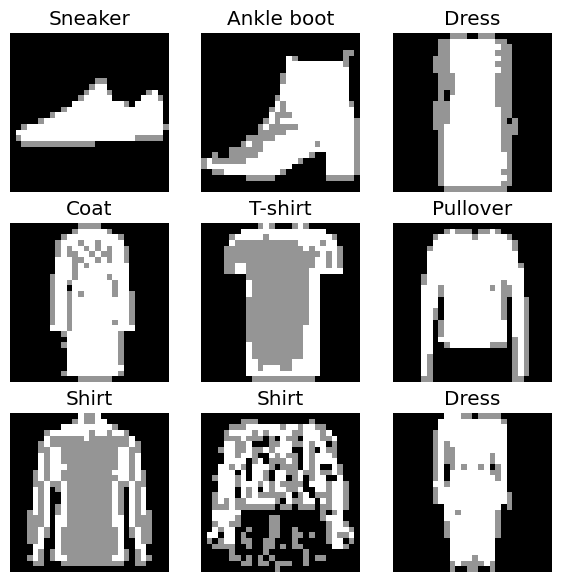

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[umbralizacion_tri]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 10620
Número total de imágenes en validación: 12000

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


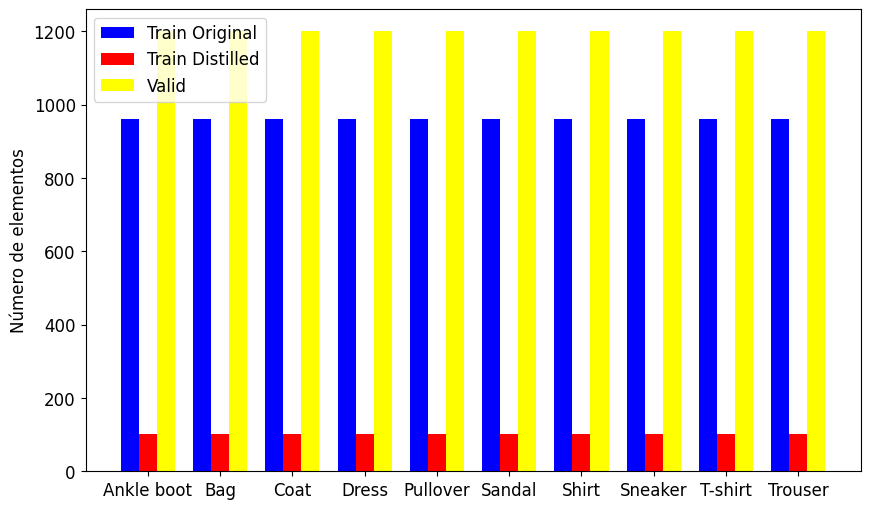

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.304567,2.304139,0.100000,0.100000,0.018182,00:27
1,2.303112,2.302605,0.100000,0.100000,0.018182,00:25
2,2.267579,2.144130,0.360750,0.360750,0.252659,00:25
3,1.262817,1.105126,0.529250,0.529250,0.485938,00:26
4,0.974684,0.942030,0.621500,0.621500,0.607658,00:27
5,0.874784,0.833316,0.681083,0.681083,0.677119,00:26
6,0.797010,0.812966,0.699667,0.699667,0.683919,00:26
7,0.752726,0.754010,0.716667,0.716667,0.708007,00:25
8,0.729298,0.722836,0.713167,0.713167,0.703559,00:26
9,0.698928,0.710077,0.727750,0.727750,0.714679,00:27



Tiempo de entrenamiento: 527.40 segundos


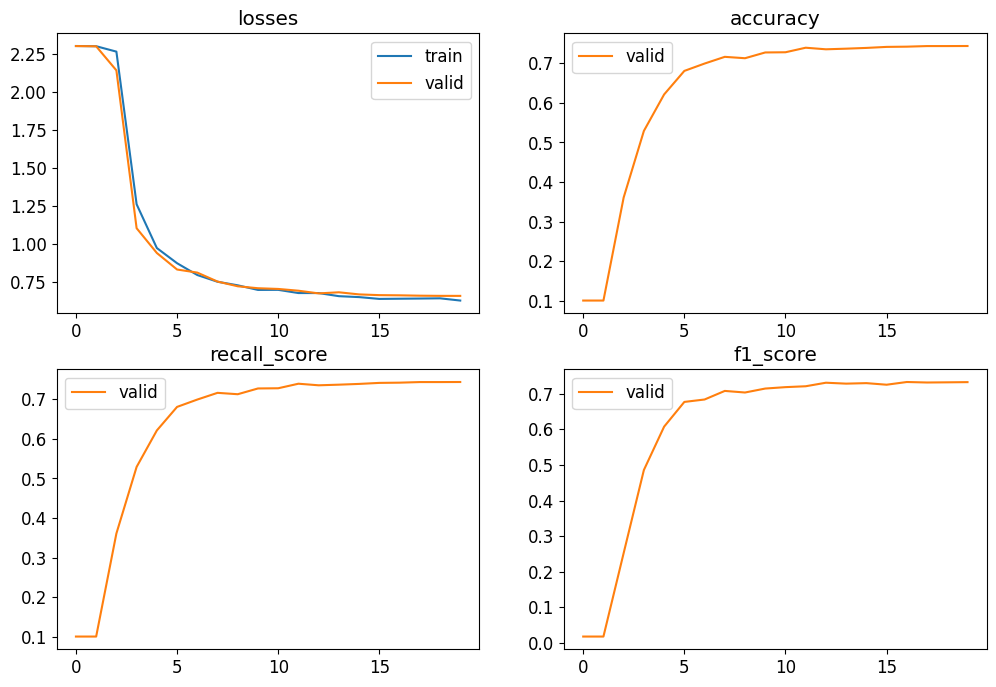

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.6597
Accuracy: 0.7441
Recall: 0.7441
F1-Score: 0.7327


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral01_001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[umbralizacion_tri]
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral01_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.0592148303985596
Accuracy: 0.5704126358032227
Recall (macro): 0.5704255858017109
F1 Score (macro): 0.5614565506192049


### Lenet 001 - Example 2

In [ ]:
create_distilled(original_path/'mnist_png'/'training', mnist_001_path, valid_ratio=0.2, fraction=0.01, mix_function=media_arit)

In [ ]:
dst = base_path / "distilled_001"

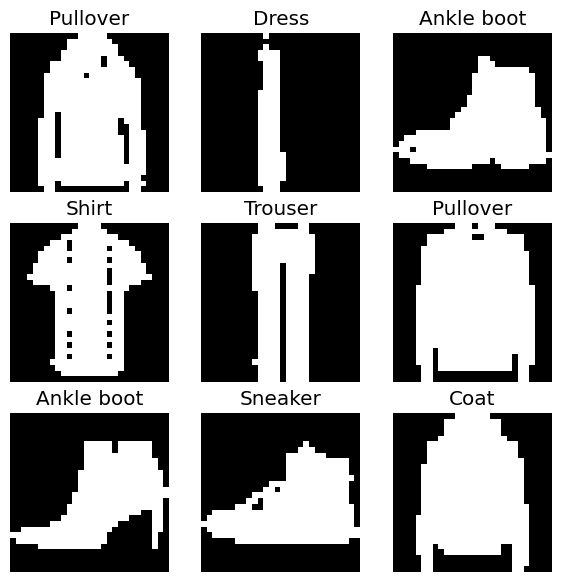

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[umbralizacion_bi]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.303710,2.303130,0.100000,0.100000,0.018182,00:25
1,2.303270,2.302690,0.100000,0.100000,0.018182,00:26
2,2.303238,2.302556,0.100000,0.100000,0.018182,00:27
3,2.174583,1.799993,0.303833,0.303833,0.224311,00:27
4,1.193063,1.064952,0.558500,0.558500,0.521249,00:26
5,1.041695,0.997578,0.602750,0.602750,0.574426,00:26
6,0.978420,0.949794,0.608083,0.608083,0.573499,00:26
7,0.894288,0.890450,0.655583,0.655583,0.633632,00:25
8,0.858808,0.820268,0.683917,0.683917,0.657028,00:26
9,0.801315,0.794986,0.705417,0.705417,0.694612,00:27



Tiempo de entrenamiento: 535.75 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.7179
Accuracy: 0.7316
Recall: 0.7316
F1-Score: 0.7211


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral02_001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[umbralizacion_bi]
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral02_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.8242257833480835
Accuracy: 0.5631009340286255
Recall (macro): 0.5631286922234987
F1 Score (macro): 0.5539323194343503


### Lenet 001 - Example 3

In [ ]:
create_distilled(original_path/'mnist_png'/'training', mnist_001_path, valid_ratio=0.2, fraction=0.01, mix_function=media_arit)

In [ ]:
dst = base_path / "distilled_001"

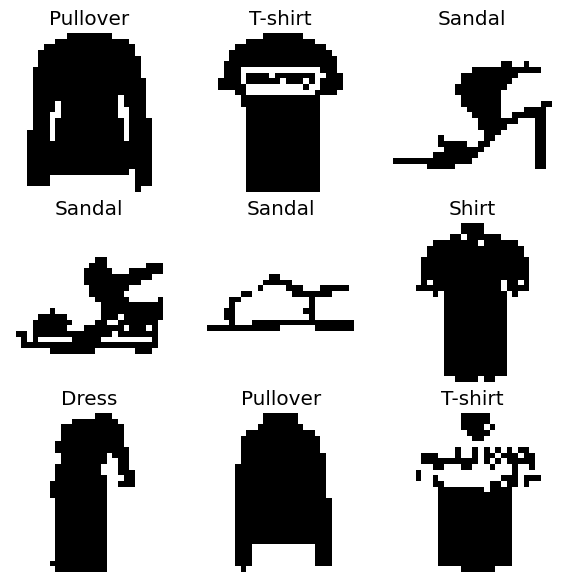

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[otsu_threshold_transform]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.250206,2.172841,0.334167,0.334167,0.236353,00:27
1,1.118086,0.904342,0.666417,0.666417,0.644373,00:27
2,0.763700,0.729629,0.716250,0.716250,0.711364,00:26
3,0.648865,0.633271,0.749500,0.749500,0.737392,00:27
4,0.588695,0.617154,0.753500,0.753500,0.733588,00:27
5,0.526822,0.533027,0.795250,0.795250,0.791402,00:27
6,0.507227,0.506291,0.811583,0.811583,0.811011,00:27
7,0.461501,0.483467,0.816833,0.816833,0.812077,00:27
8,0.453674,0.510526,0.807667,0.807667,0.809854,00:26
9,0.415329,0.467265,0.824833,0.824833,0.821818,00:26



Tiempo de entrenamiento: 542.63 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.4191
Accuracy: 0.8428
Recall: 0.8428
F1-Score: 0.8424


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral03_001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[otsu_threshold_transform]
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral03_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.4169013500213623
Accuracy: 0.6640625
Recall (macro): 0.6638487934412169
F1 Score (macro): 0.66145175166885


## Lenet 005

In [ ]:
dst = base_path / "distilled_005"

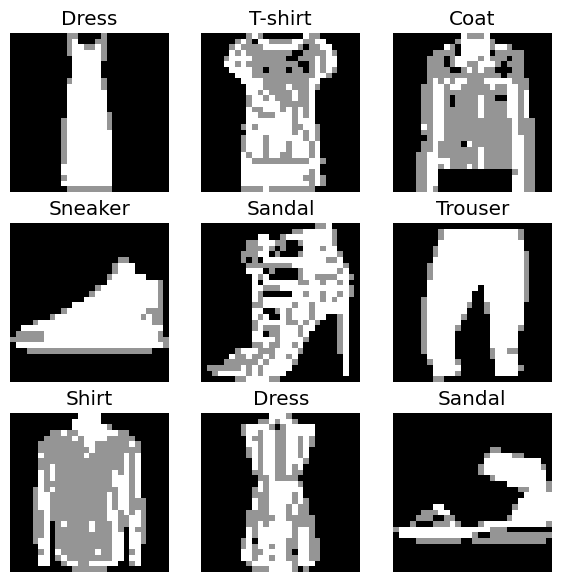

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[umbralizacion_tri]

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 9800
Número total de imágenes en validación: 12000

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


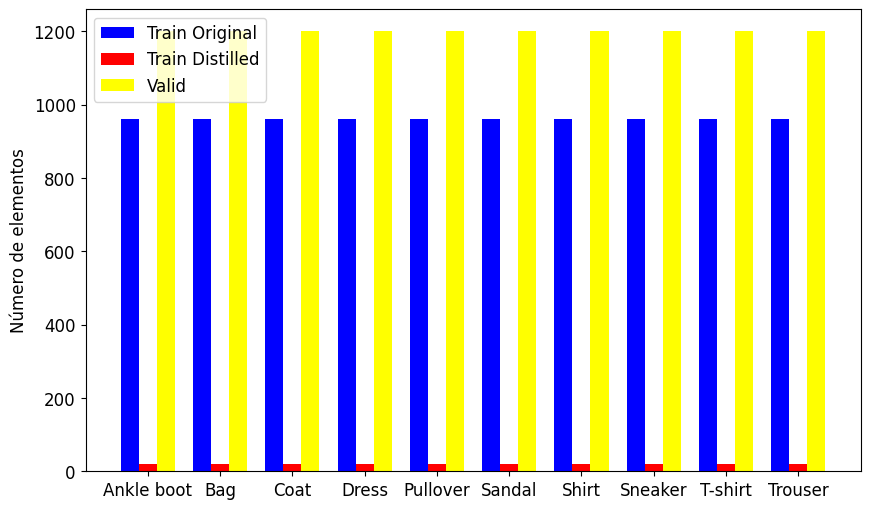

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.303442,2.303454,0.100000,0.100000,0.018182,00:24
1,2.302914,2.302745,0.100000,0.100000,0.018182,00:24
2,2.301349,2.295560,0.235000,0.235000,0.154514,00:26
3,1.329895,1.053090,0.575167,0.575167,0.556465,00:25
4,0.956431,0.941910,0.601833,0.601833,0.580725,00:25
5,0.848231,0.841653,0.670750,0.670750,0.668378,00:24
6,0.814589,0.798338,0.682833,0.682833,0.662456,00:25
7,0.766417,0.755703,0.708250,0.708250,0.701697,00:25
8,0.726242,0.732872,0.714167,0.714167,0.699023,00:25
9,0.704463,0.694420,0.732833,0.732833,0.724638,00:23



Tiempo de entrenamiento: 508.88 segundos


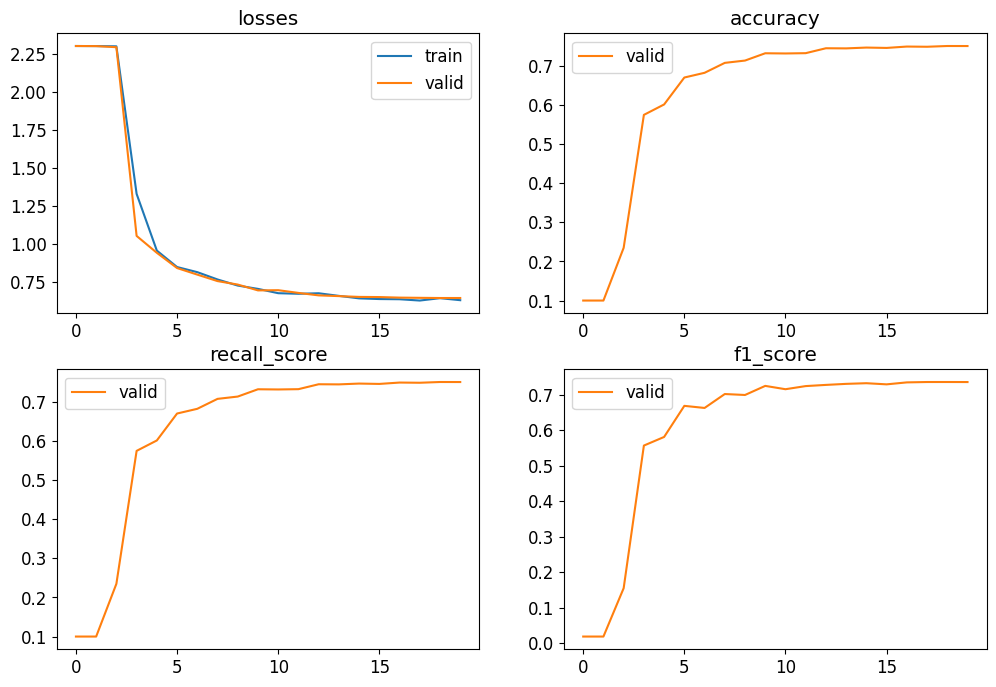

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.6444
Accuracy: 0.7513
Recall: 0.7513
F1-Score: 0.7355


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral01_005_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[umbralizacion_tri]
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral01_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.9639145135879517
Accuracy: 0.5762219429016113
Recall (macro): 0.5760533528224027
F1 Score (macro): 0.5609306152823305


### Lenet 005 - Example 2

In [ ]:
create_distilled(original_path/'mnist_png'/'training', mnist_005_path, valid_ratio=0.2, fraction=0.05, mix_function=media_arit)

In [ ]:
dst = base_path / "distilled_005"

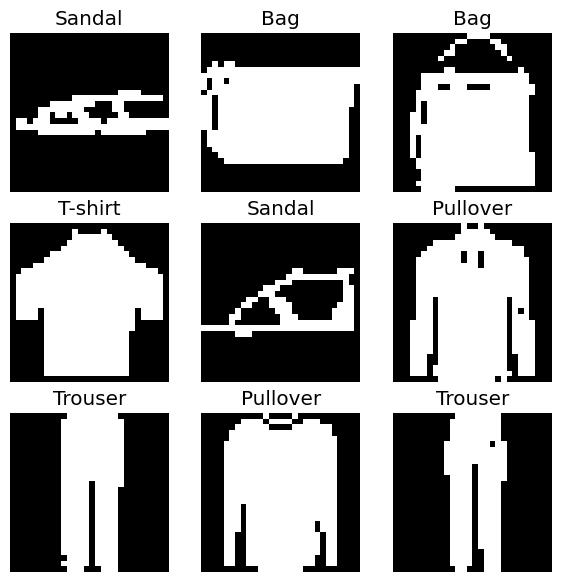

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[umbralizacion_bi]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.304734,2.303840,0.100000,0.100000,0.018182,00:25
1,2.303090,2.302792,0.100000,0.100000,0.018182,00:24
2,2.302339,2.300781,0.100000,0.100000,0.018182,00:24
3,1.834144,1.567452,0.447750,0.447750,0.386338,00:25
4,1.266647,1.144722,0.556083,0.556083,0.508630,00:25
5,1.057329,1.017233,0.607583,0.607583,0.586131,00:23
6,0.957852,0.926956,0.632167,0.632167,0.603317,00:25
7,0.890144,0.879568,0.665250,0.665250,0.663892,00:25
8,0.864208,0.872137,0.663083,0.663083,0.640971,00:25
9,0.824259,0.828428,0.676250,0.676250,0.658081,00:23



Tiempo de entrenamiento: 523.55 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.7309
Accuracy: 0.7244
Recall: 0.7244
F1-Score: 0.7113


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral02_005_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[umbralizacion_bi]
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral02_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 1.7490596771240234
Accuracy: 0.5587940812110901
Recall (macro): 0.5586936640308428
F1 Score (macro): 0.5421522542364496


### Lenet 005 - Example 3

In [ ]:
create_distilled(original_path/'mnist_png'/'training', mnist_005_path, valid_ratio=0.2, fraction=0.05, mix_function=media_arit)

In [ ]:
dst = base_path / "distilled_005"

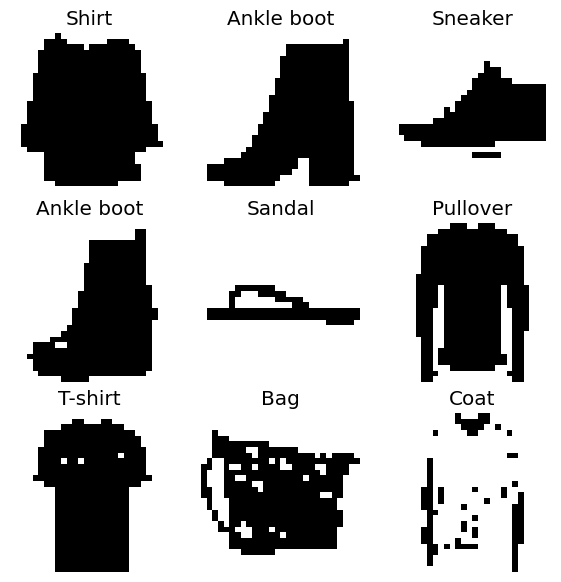

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[otsu_threshold_transform]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.279967,2.247636,0.353083,0.353083,0.232807,00:26
1,1.273668,0.968911,0.671833,0.671833,0.651090,00:25
2,0.795053,0.728521,0.736917,0.736917,0.731802,00:26
3,0.683122,0.675257,0.743250,0.743250,0.727582,00:26
4,0.613764,0.587727,0.775333,0.775333,0.769932,00:27
5,0.578754,0.554089,0.795917,0.795917,0.792055,00:24
6,0.537370,0.524028,0.807167,0.807167,0.805242,00:26
7,0.505248,0.531737,0.800500,0.800500,0.798677,00:25
8,0.476588,0.501939,0.814917,0.814917,0.812609,00:27
9,0.452478,0.494003,0.816750,0.816750,0.818356,00:24



Tiempo de entrenamiento: 523.88 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.4337
Accuracy: 0.8409
Recall: 0.8409
F1-Score: 0.8388


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral03_005_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[otsu_threshold_transform]
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral03_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.254868268966675
Accuracy: 0.6605569124221802
Recall (macro): 0.6605377607440601
F1 Score (macro): 0.6606985428799826


## Lenet 0001

In [ ]:
dst = base_path / "distilled_0001"

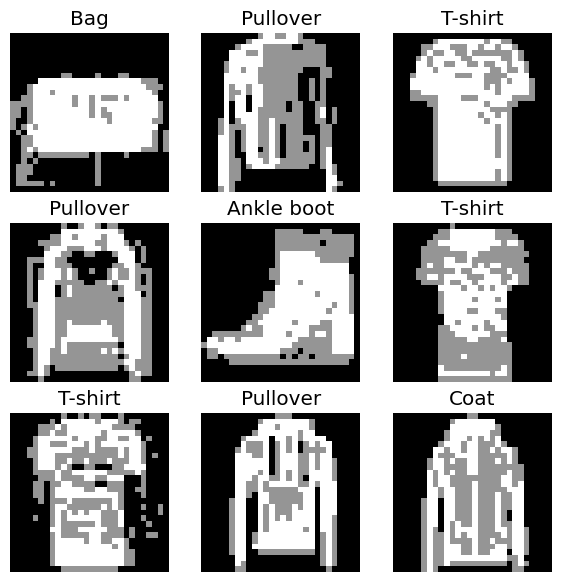

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[umbralizacion_tri]

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 22400
Número total de imágenes en validación: 12000

Clases: ['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt', 'Trouser']


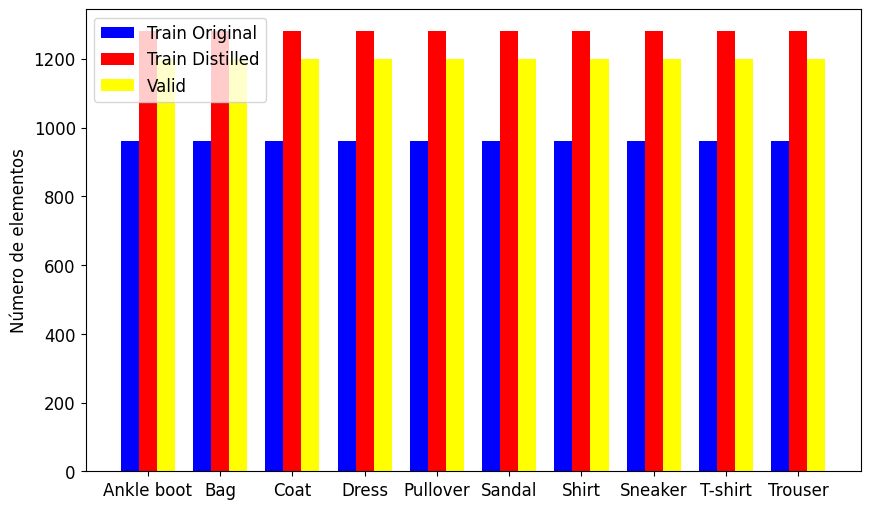

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.303695,2.303358,0.100000,0.100000,0.018182,00:41
1,2.302437,2.301391,0.100000,0.100000,0.024087,00:40
2,1.192073,1.068858,0.554167,0.554167,0.528146,00:41
3,0.771555,0.928501,0.630583,0.630583,0.616866,00:41
4,0.693026,0.872971,0.668750,0.668750,0.659481,00:41
5,0.629244,0.796528,0.695083,0.695083,0.677399,00:40
6,0.587704,0.789705,0.688500,0.688500,0.668674,00:41
7,0.554048,0.756253,0.703583,0.703583,0.700018,00:42
8,0.526442,0.726926,0.720417,0.720417,0.714154,00:41
9,0.538020,0.714843,0.717417,0.717417,0.706719,00:41



Tiempo de entrenamiento: 838.66 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.6590
Accuracy: 0.7510
Recall: 0.7510
F1-Score: 0.7448


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral01_0001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[umbralizacion_tri]
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral01_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.310899257659912
Accuracy: 0.5757211446762085
Recall (macro): 0.5756160810108705
F1 Score (macro): 0.573552444651989


### Lenet 0001 - Example 2

In [ ]:
create_distilled(original_path/'mnist_png'/'training', mnist_0001_path, valid_ratio=0.2, fraction=0.001, mix_function=media_arit)

In [ ]:
dst = base_path / "distilled_0001"

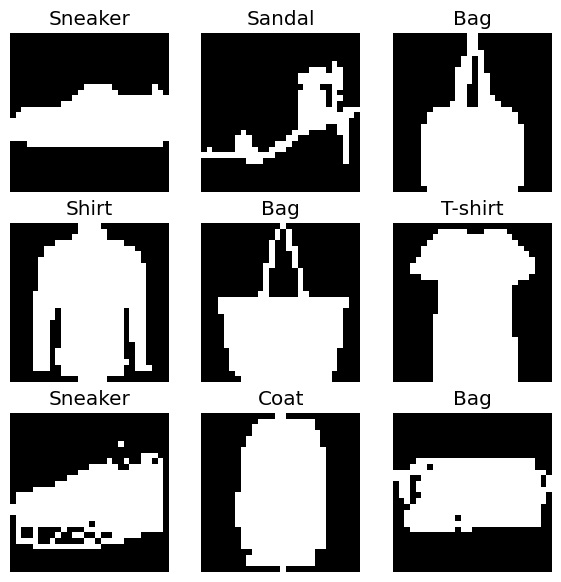

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[umbralizacion_bi]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.304445,2.303717,0.100000,0.100000,0.018182,00:42
1,2.303028,2.302658,0.100000,0.100000,0.018182,00:41
2,1.793344,1.605417,0.373500,0.373500,0.280097,00:41
3,0.894095,1.068595,0.562750,0.562750,0.528896,00:41
4,0.748675,0.895716,0.657167,0.657167,0.652649,00:42
5,0.680291,0.837920,0.692083,0.692083,0.684579,00:42
6,0.637812,0.768215,0.717250,0.717250,0.710601,00:42
7,0.581754,0.782650,0.718417,0.718417,0.709677,00:42
8,0.572518,0.743476,0.731583,0.731583,0.725994,00:42
9,0.539150,0.765256,0.720167,0.720167,0.717212,00:42



Tiempo de entrenamiento: 839.63 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.6701
Accuracy: 0.7531
Recall: 0.7531
F1-Score: 0.7498


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral02_0001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[umbralizacion_bi]
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral02_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 2.453655242919922
Accuracy: 0.5845352411270142
Recall (macro): 0.5846058382645265
F1 Score (macro): 0.5814839951851177


### Lenet 0001 - Example 3

In [ ]:
create_distilled(original_path/'mnist_png'/'training', mnist_0001_path, valid_ratio=0.2, fraction=0.001, mix_function=media_arit)

In [ ]:
dst = base_path / "distilled_0001"

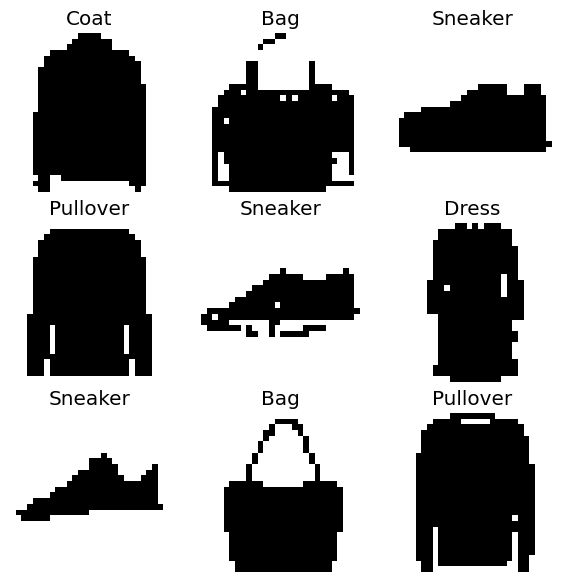

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[otsu_threshold_transform]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.497001,1.245946,0.545750,0.545750,0.487938,00:41
1,0.667907,0.786729,0.714417,0.714417,0.698217,00:41
2,0.531197,0.668195,0.750000,0.750000,0.735968,00:40
3,0.462352,0.713059,0.739750,0.739750,0.732451,00:39
4,0.409045,0.541104,0.795250,0.795250,0.795365,00:41
5,0.398870,0.523060,0.804583,0.804583,0.796102,00:41
6,0.354478,0.484998,0.820417,0.820417,0.819554,00:40
7,0.337454,0.466804,0.828250,0.828250,0.828386,00:40
8,0.313862,0.449832,0.836167,0.836167,0.833401,00:41
9,0.284024,0.452845,0.839583,0.839583,0.835394,00:43


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral03_0001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[otsu_threshold_transform]
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral03_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

## Resnet 001

In [13]:
def umbralizacion_tri(img: PILImage):
    img.quantize(colors=3)
    return img.convert("RGB")

In [14]:
def umbralizacion_bi(img: PILImage):
    img.quantize(colors=2)
    return img.convert("RGB")

In [15]:
import cv2

def otsu_threshold_transform(img: PILImage):
    img_gray = img.convert("L")
    img_array = np.array(img_gray)
    _, thresholded = cv2.threshold(img_array, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return PILImage.create(thresholded).convert("RGB")


In [16]:
dst = base_path / "distilled_001"

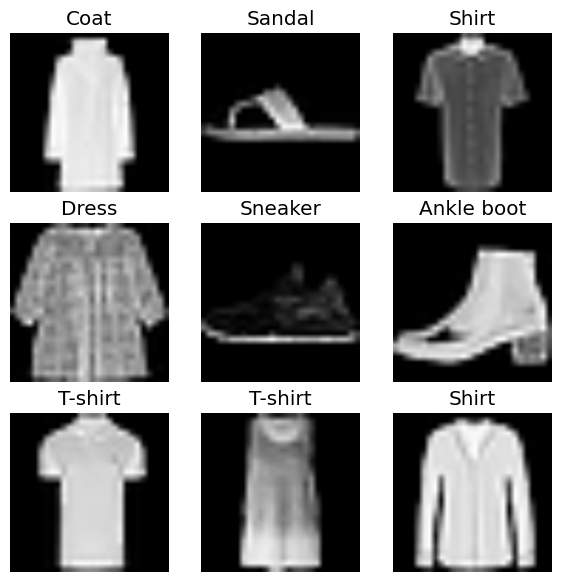

In [17]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[umbralizacion_tri, Resize(224)]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [18]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


In [19]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.419699,0.904001,0.677917,0.677917,0.673390,01:03


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.746911,0.635398,0.767917,0.767917,0.766833,01:07
1,0.516988,0.593104,0.800833,0.800833,0.795010,01:09
2,0.367542,0.665575,0.789333,0.789333,0.787423,01:09
3,0.272893,0.602296,0.808667,0.808667,0.805937,01:08
4,0.231950,0.669619,0.804000,0.804000,0.803059,01:08
5,0.211671,0.769418,0.790417,0.790417,0.784536,01:08
6,0.146778,0.740910,0.794583,0.794583,0.794556,01:22
7,0.107898,0.777504,0.818500,0.818500,0.808995,01:08
8,0.084757,0.870169,0.807333,0.807333,0.802336,01:08
9,0.056067,0.742171,0.823250,0.823250,0.824304,01:22


No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 924.89 segundos


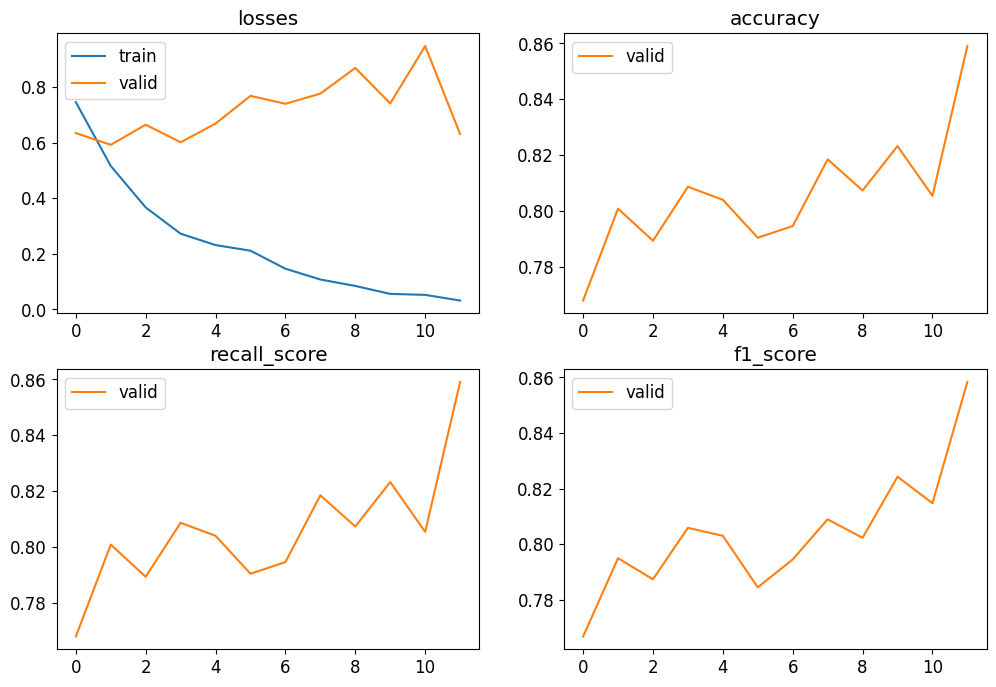

In [20]:
learn.recorder.plot_metrics()

In [21]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.6320
Accuracy: 0.8591
Recall: 0.8591
F1-Score: 0.8584


In [22]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral01_001_v3.pkl')

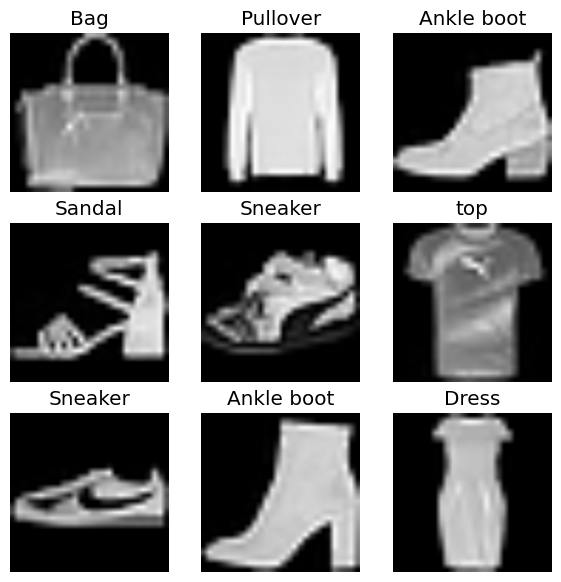

In [25]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[umbralizacion_tri, Resize(224)],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

test_dls.show_batch(max_n=9, figsize=(7,7))

In [26]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral01_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [27]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.052781105041504
Accuracy: 0.674879789352417
Recall (macro): 0.6748814102460657
F1 Score (macro): 0.6720054468186729


### Resnet 001 - Example 2

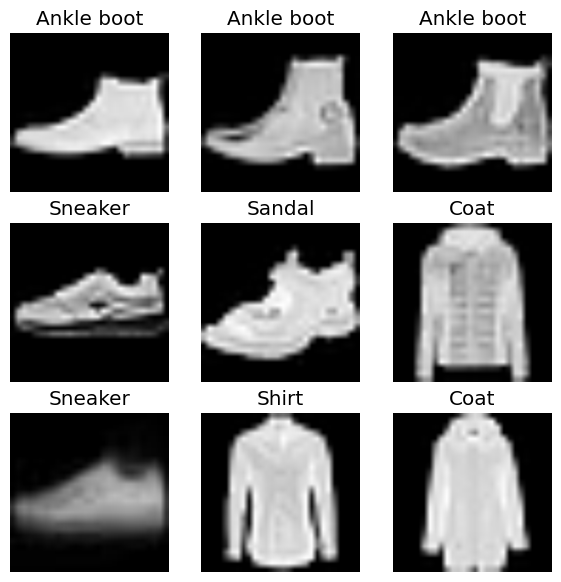

In [28]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_bi]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [29]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [30]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.401794,0.937776,0.671417,0.671417,0.659016,01:01


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.776206,0.623931,0.774167,0.774167,0.771796,01:07
1,0.519114,0.588292,0.795000,0.795000,0.792602,01:07
2,0.375723,0.636606,0.785583,0.785583,0.782636,01:07
3,0.295967,0.679881,0.793417,0.793417,0.785056,01:08
4,0.227222,0.704411,0.808667,0.808667,0.794468,01:08
5,0.206324,0.712014,0.803250,0.803250,0.801705,01:08
6,0.133639,0.793473,0.814083,0.814083,0.808589,01:08


No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 537.79 segundos


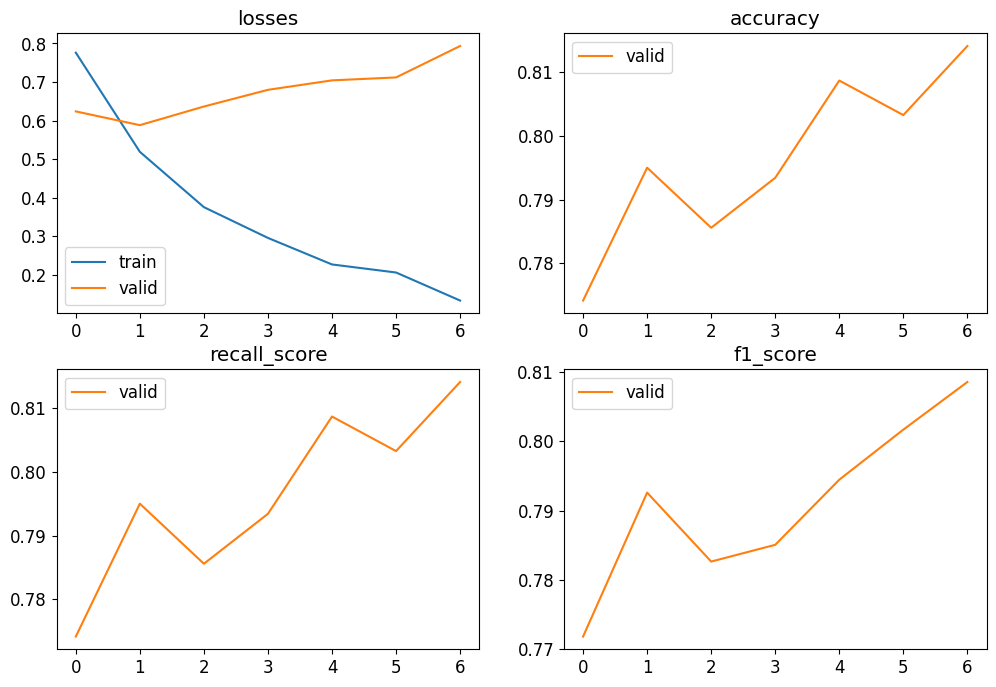

In [31]:
learn.recorder.plot_metrics()

In [32]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.7935
Accuracy: 0.8141
Recall: 0.8141
F1-Score: 0.8086


In [33]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral02_001_v3.pkl')

In [34]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_bi],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [35]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral02_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [36]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.8804805278778076
Accuracy: 0.6365184187889099
Recall (macro): 0.6365618178571172
F1 Score (macro): 0.6299878569111795


### Resnet 001 - Example 3

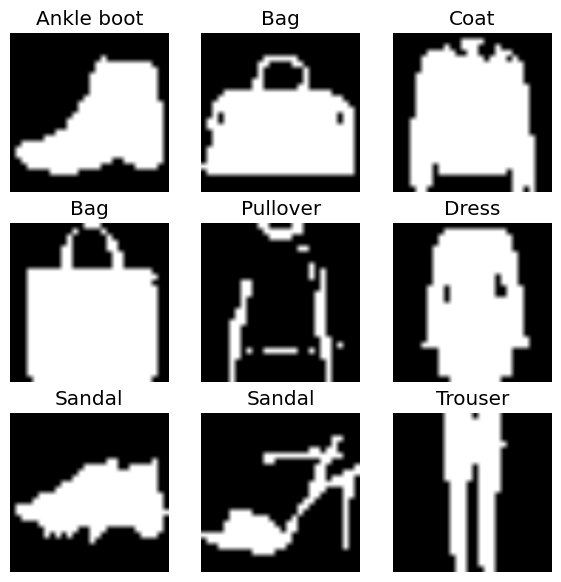

In [37]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), otsu_threshold_transform]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [38]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


In [39]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.331389,0.865013,0.703083,0.703083,0.698521,01:00


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.780037,0.632402,0.776500,0.776500,0.775134,01:06
1,0.526301,0.604595,0.788250,0.788250,0.784423,01:07
2,0.395446,0.680848,0.775250,0.775250,0.775520,01:07
3,0.328647,0.707078,0.794833,0.794833,0.789918,01:07
4,0.268900,0.731676,0.796667,0.796667,0.788742,01:06
5,0.245990,0.752034,0.792917,0.792917,0.791894,01:07
6,0.178135,0.742944,0.807667,0.807667,0.805402,01:07
7,0.146110,0.758341,0.800333,0.800333,0.802358,01:07
8,0.136101,0.975935,0.773000,0.773000,0.769770,01:07
9,0.085906,0.932328,0.794417,0.794417,0.790921,01:07


No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 869.26 segundos


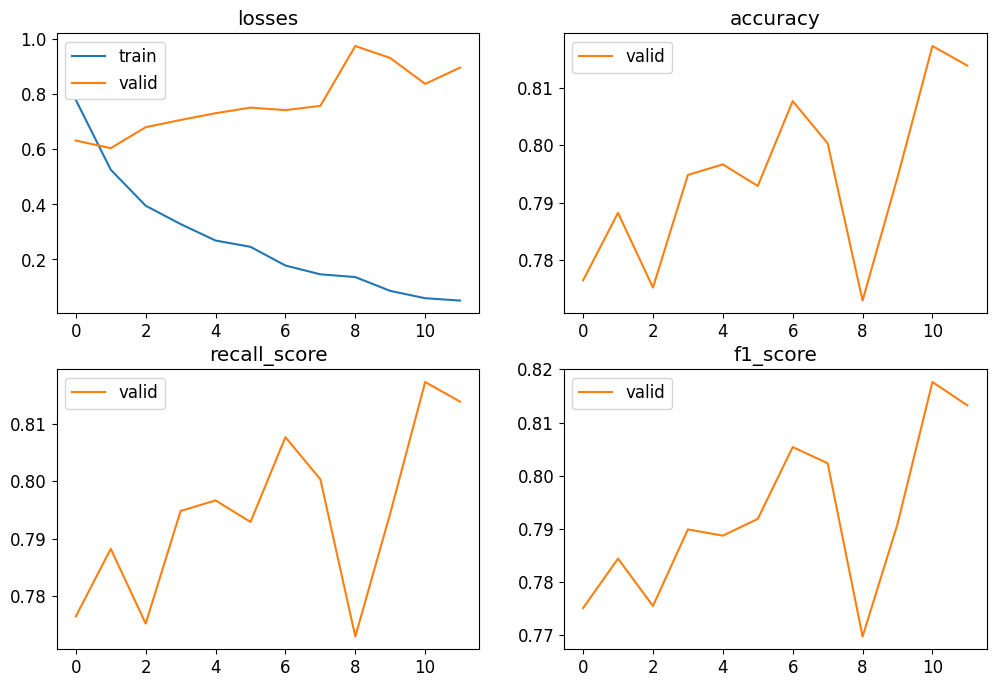

In [40]:
learn.recorder.plot_metrics()

In [41]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.8975
Accuracy: 0.8138
Recall: 0.8138
F1-Score: 0.8132


In [42]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_001_v3.pkl')

In [43]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), otsu_threshold_transform],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [44]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [45]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.732447624206543
Accuracy: 0.6338140964508057
Recall (macro): 0.633461184793821
F1 Score (macro): 0.6332789982149196


## Resnet 005

In [46]:
dst = base_path / "distilled_005"

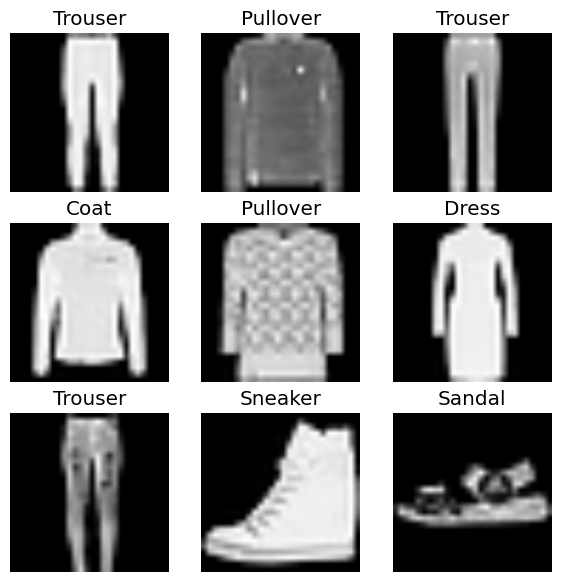

In [47]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_tri]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [48]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


In [49]:
start_time = time.time()
#learn.fit_one_cycle(60)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.427632,0.898260,0.702667,0.702667,0.692383,00:59


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.776912,0.634480,0.773583,0.773583,0.767530,01:05
1,0.559866,0.613233,0.791333,0.791333,0.784158,01:04
2,0.394766,0.626341,0.800667,0.800667,0.799951,01:05
3,0.339853,0.724224,0.784750,0.784750,0.780859,01:05
4,0.228194,0.738661,0.794583,0.794583,0.789770,01:04
5,0.203440,0.767833,0.798583,0.798583,0.792193,01:04
6,0.145321,0.663094,0.827750,0.827750,0.829931,01:05
7,0.119165,0.683344,0.830500,0.830500,0.829999,01:05
8,0.094106,0.757108,0.820667,0.820667,0.820837,01:04
9,0.073379,0.761106,0.833083,0.833083,0.827866,01:04


No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 843.76 segundos


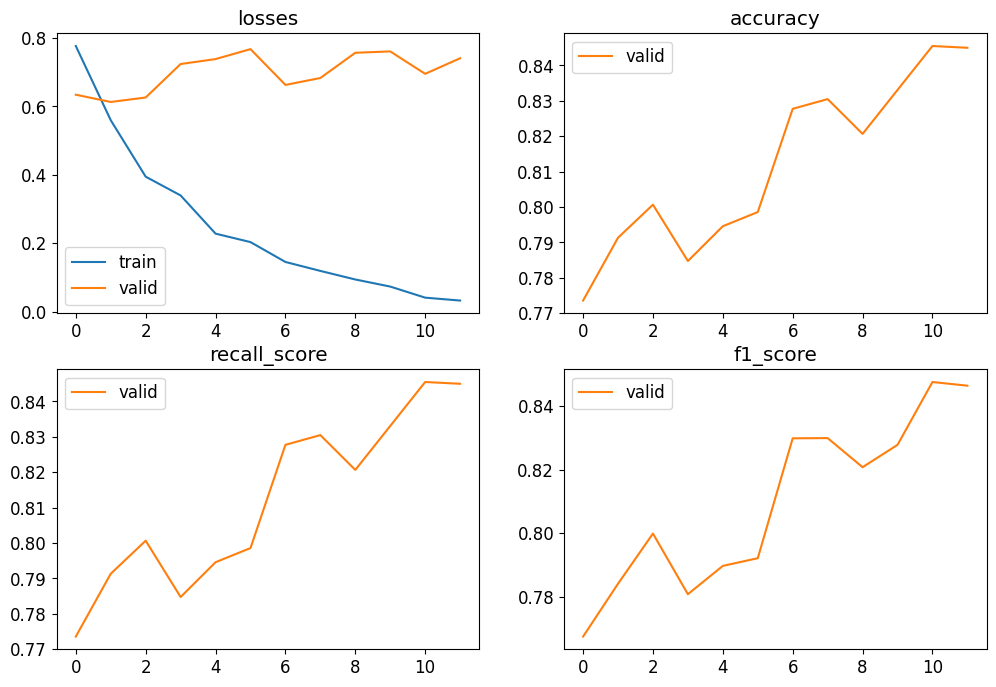

In [50]:
learn.recorder.plot_metrics()

In [51]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.7411
Accuracy: 0.8450
Recall: 0.8450
F1-Score: 0.8465


In [52]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral01_005_v3.pkl')

In [53]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_tri],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [54]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral01_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [55]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 3.97749400138855
Accuracy: 0.6710737347602844
Recall (macro): 0.671007429572654
F1 Score (macro): 0.6648194995425094


### Resnet 005 - Example 2

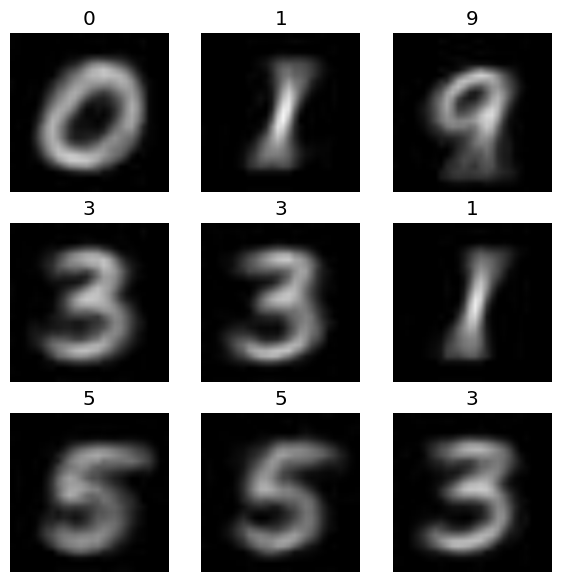

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_bi]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.5MB/s]


In [ ]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.600949,4.076629,0.211409,0.205739,0.154199,00:08


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.020374,3.431494,0.226510,0.225278,0.168860,00:08
1,0.011771,3.045543,0.312081,0.302937,0.217840,00:09
2,0.007347,3.515675,0.270134,0.264038,0.203080,00:09
3,0.004870,3.690595,0.303691,0.294617,0.204133,00:08
4,0.003322,4.112275,0.286913,0.277520,0.172041,00:06
5,0.002624,4.326322,0.276846,0.267932,0.152107,00:06
6,0.002021,4.671216,0.280201,0.270630,0.162756,00:06
7,0.001480,4.758033,0.280201,0.270600,0.161558,00:06
8,0.001101,4.783267,0.273490,0.264225,0.157904,00:04
9,0.000832,4.951801,0.255034,0.247230,0.159905,00:05


No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 91.90 segundos


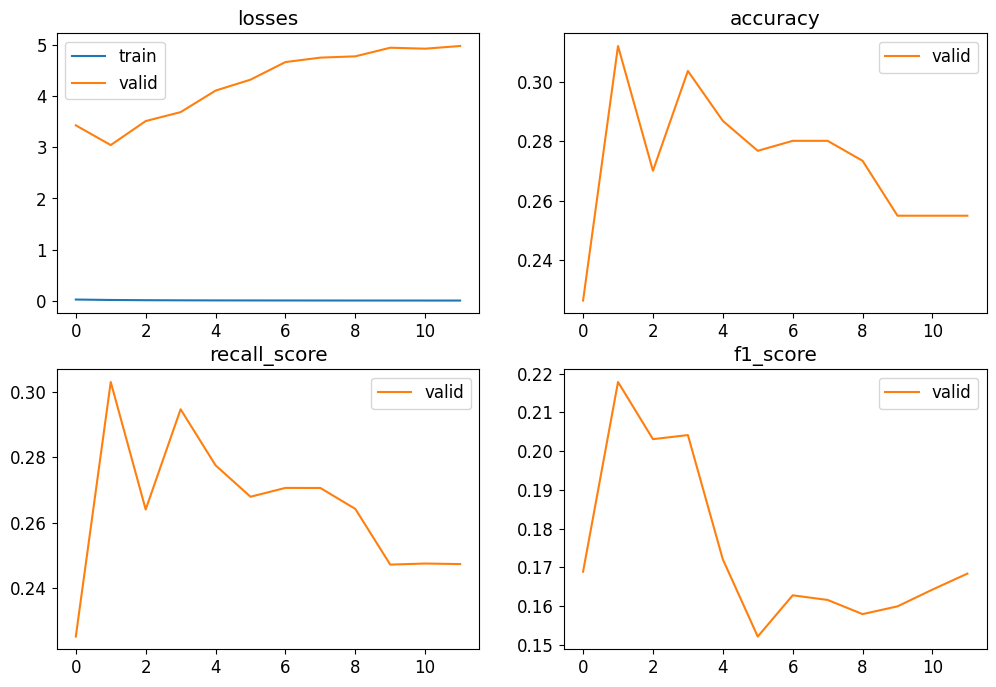

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 4.9857
Accuracy: 0.2550
Recall: 0.2474
F1-Score: 0.1684


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral02_005_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_bi]
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral02_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.473205089569092
Accuracy: 0.12299679219722748
Recall (macro): 0.1264540437826184
F1 Score (macro): 0.08181593224962938


### Resnet 005 - Example 3

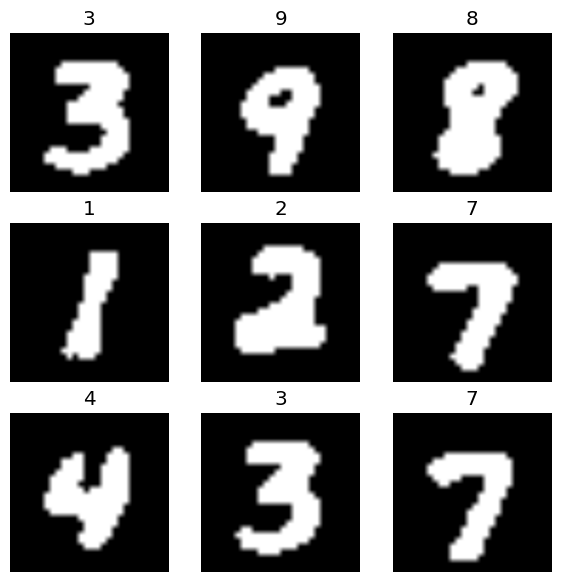

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), otsu_threshold_transform]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


In [ ]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.858702,2.382666,0.089863,0.087961,0.029332,00:54
1,1.667808,2.882605,0.112371,0.100000,0.020207,00:48
2,1.119821,4.834867,0.112371,0.100000,0.020204,00:46
3,0.822631,7.896064,0.112371,0.100000,0.020204,00:49
4,0.639770,10.505170,0.112371,0.100000,0.020204,00:47
5,0.518045,12.379988,0.112371,0.100000,0.020204,00:34
6,0.431091,13.958188,0.112371,0.100000,0.020204,00:36
7,0.365687,15.686097,0.112371,0.100000,0.020204,00:34
8,0.314743,17.237045,0.112371,0.100000,0.020204,00:34
9,0.274105,18.539742,0.112371,0.100000,0.020204,00:35


No improvement since epoch 0: early stopping

Tiempo de entrenamiento: 456.00 segundos


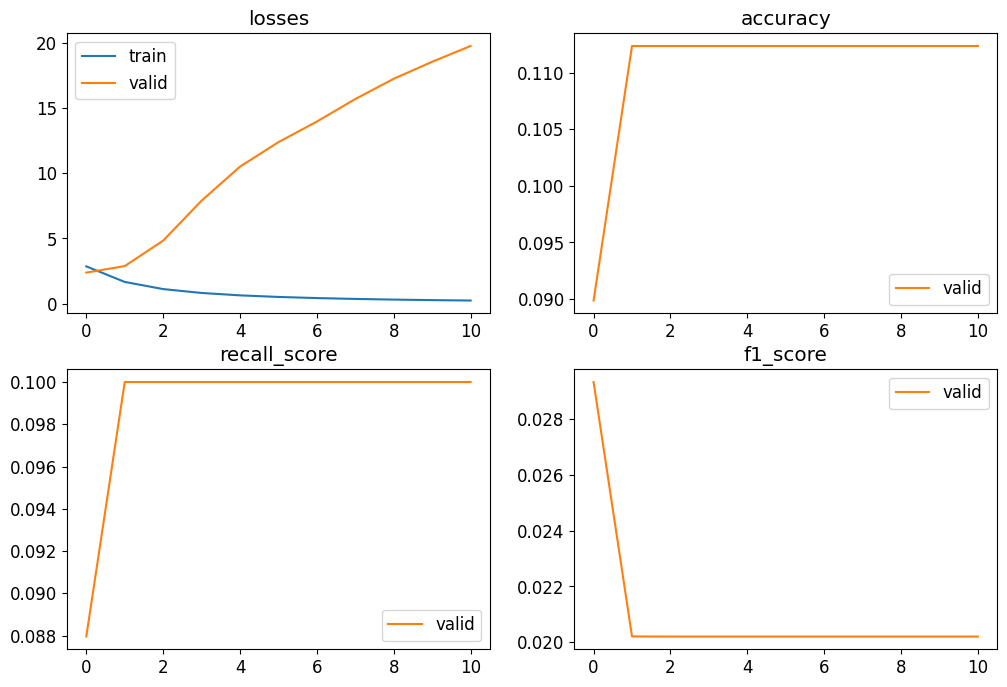

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_005_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), otsu_threshold_transform],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

## Resnet 0001

In [ ]:
dst = base_path / "distilled_0001"

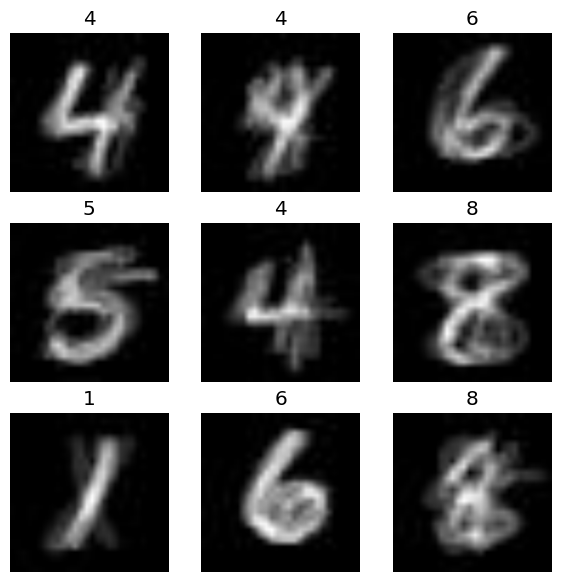

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[umbralizacion_tri, Resize(224)]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.427454,6.182950,0.280854,0.283713,0.264968,00:56
1,0.066974,1.644853,0.608572,0.612380,0.578413,00:53
2,0.020742,1.348376,0.687625,0.685604,0.653005,00:54
3,0.013390,3.834450,0.386591,0.386307,0.373893,00:55
4,0.016162,0.995776,0.760173,0.760174,0.762747,00:52
5,0.016076,1.591527,0.672115,0.670328,0.658248,00:53
6,0.023060,0.784823,0.829219,0.827274,0.827621,00:56
7,0.020433,1.605076,0.737492,0.735171,0.753512,00:54
8,0.018071,0.665880,0.846064,0.843937,0.846327,00:54
9,0.014724,0.751802,0.843396,0.843495,0.842330,00:55


No improvement since epoch 23: early stopping

Tiempo de entrenamiento: 1574.68 segundos


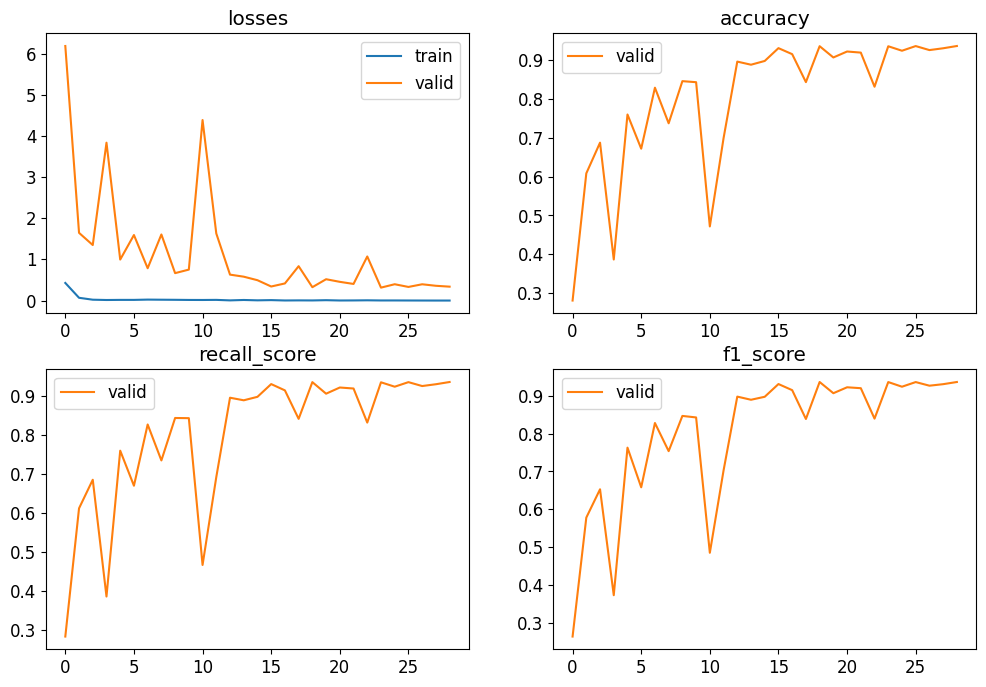

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.3375
Accuracy: 0.9366
Recall: 0.9362
F1-Score: 0.9357


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral01_0001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[umbralizacion_tri, Resize(224)]
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)
test_dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral01_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

### Resnet 0001 - Example 2

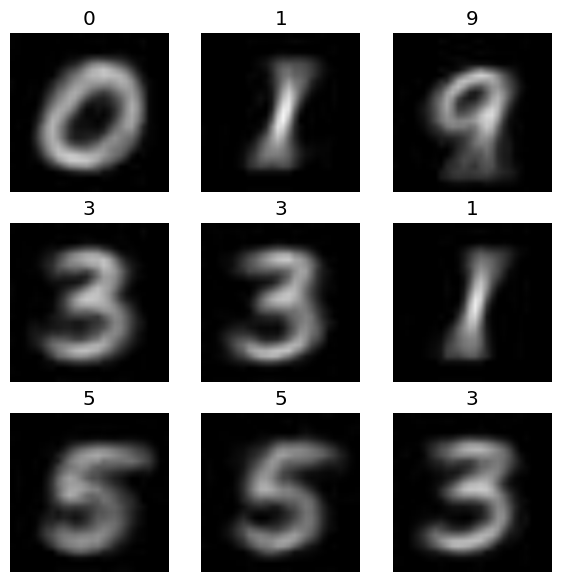

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_bi]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.5MB/s]


In [ ]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.600949,4.076629,0.211409,0.205739,0.154199,00:08


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.020374,3.431494,0.226510,0.225278,0.168860,00:08
1,0.011771,3.045543,0.312081,0.302937,0.217840,00:09
2,0.007347,3.515675,0.270134,0.264038,0.203080,00:09
3,0.004870,3.690595,0.303691,0.294617,0.204133,00:08
4,0.003322,4.112275,0.286913,0.277520,0.172041,00:06
5,0.002624,4.326322,0.276846,0.267932,0.152107,00:06
6,0.002021,4.671216,0.280201,0.270630,0.162756,00:06
7,0.001480,4.758033,0.280201,0.270600,0.161558,00:06
8,0.001101,4.783267,0.273490,0.264225,0.157904,00:04
9,0.000832,4.951801,0.255034,0.247230,0.159905,00:05


No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 91.90 segundos


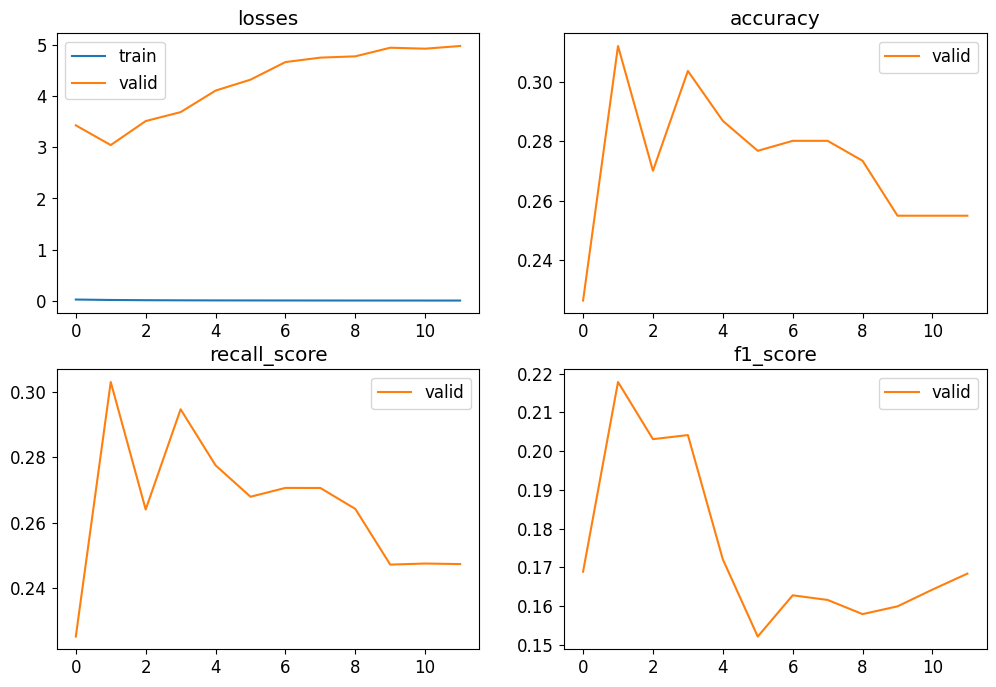

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 4.9857
Accuracy: 0.2550
Recall: 0.2474
F1-Score: 0.1684


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_0001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_bi],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.473205089569092
Accuracy: 0.12299679219722748
Recall (macro): 0.1264540437826184
F1 Score (macro): 0.08181593224962938


### Resnet 0001 - Example 3

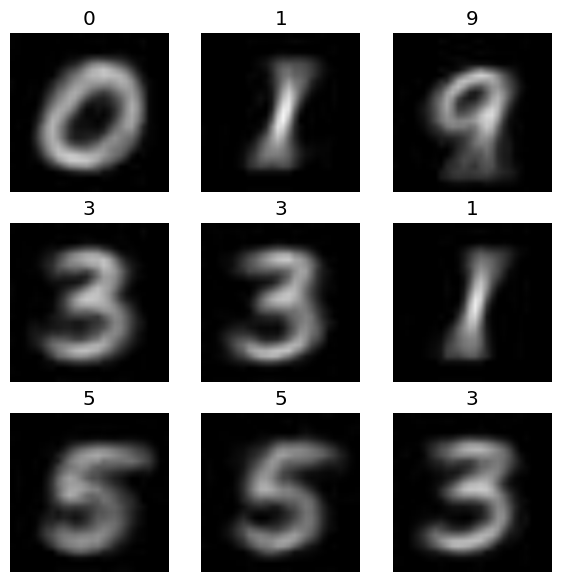

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), otsu_threshold_transform]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.5MB/s]


In [ ]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.600949,4.076629,0.211409,0.205739,0.154199,00:08


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.020374,3.431494,0.226510,0.225278,0.168860,00:08
1,0.011771,3.045543,0.312081,0.302937,0.217840,00:09
2,0.007347,3.515675,0.270134,0.264038,0.203080,00:09
3,0.004870,3.690595,0.303691,0.294617,0.204133,00:08
4,0.003322,4.112275,0.286913,0.277520,0.172041,00:06
5,0.002624,4.326322,0.276846,0.267932,0.152107,00:06
6,0.002021,4.671216,0.280201,0.270630,0.162756,00:06
7,0.001480,4.758033,0.280201,0.270600,0.161558,00:06
8,0.001101,4.783267,0.273490,0.264225,0.157904,00:04
9,0.000832,4.951801,0.255034,0.247230,0.159905,00:05


No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 91.90 segundos


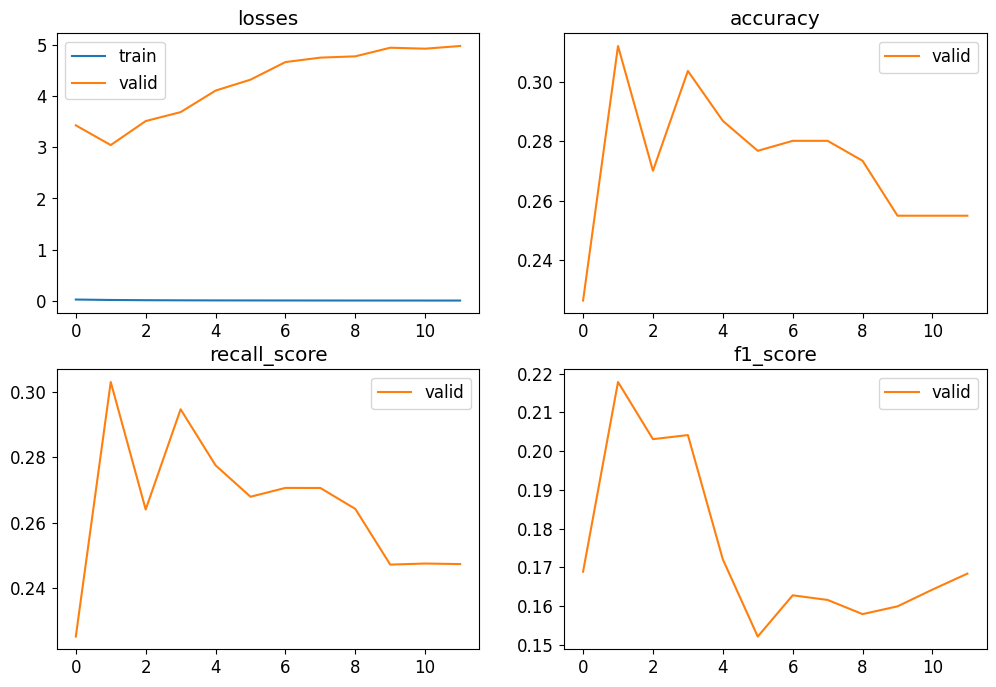

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 4.9857
Accuracy: 0.2550
Recall: 0.2474
F1-Score: 0.1684


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_0001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), otsu_threshold_transform]
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(test_path)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.473205089569092
Accuracy: 0.12299679219722748
Recall (macro): 0.1264540437826184
F1 Score (macro): 0.08181593224962938
